# 2.4 DustPyLib

Because it is rather easy to add new features into DustPy via the updaters, it is straightforward to share new features with others.  
[DustPyLib](https://dustpylib.readthedocs.io/en/latest/) is a library of extensions auxiliary modules for DustPy.

In this notebook we are going to use DustPyLib to set up a DustPy simulation with planets and try to make an observation of the disk with [RADMC-3D](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/). We are setting up the dust model with simple power laws to avoid having to run a simulation here.  
`RADMC-3D` has to be installed manually to fully follow all cells in this notebook.

The first steps are identical to previous examples.

In [1]:
from dustpy import Simulation
from dustpy import constants as c

In [2]:
sim = Simulation()

For this example we reduce the minimum particle size by one order of magnitude and allow particles even if they are above the drift limit, since we are overwriting the dust surface densities later anyway.

In [3]:
sim.ini.grid.mmin /= 1.e3
sim.ini.dust.allowDriftingParticles = True

In this model we want to include a few planets. Semi-major axis, mass and planet name are defined in a dictionary, which will be used to set up the model.

In [4]:
planets = {
    "Jupiter": {
        "a":   5.2038  * c.au,
        "M": 317.8     * c.M_earth,
    },
    "Saturn": {
        "a":   9.5826  * c.au,
        "M":  95.159   * c.M_earth,
    },
    "Uranus": {
        "a":  19.19126 * c.au,
        "M":  14.536   * c.M_earth,
    },
    "Neptune": {
        "a":  30.07    * c.au,
        "M":  17.147   * c.M_earth,
    },
}

We want to have a finer radial grid resolution at the planet locations. We therefore have to set a custom grid. First we create the radial grid interfaces logarithmically with the parameters in `sim.ini` and then use the `refine_radial_local` method from `DustPyLib` to refine the grid at the planet locations.

In [5]:
from dustpylib.grid.refinement import refine_radial_local
import numpy as np

In [6]:
print(refine_radial_local.__doc__)


    Function refines the radial grid locally bysplitting grid cells
    recursively at a specific location.

    Parameters
    ----------
    ri : array-like, (Nr,)
        Radial grid cell interfaces
    r0 : float
        Radial location to be refined
    num : int, optional, default: 3
        Number of refinement steps

    Returns
    -------
    ri_fine : array-like, (Nr+,)
        Refined radial grid cell interfaces
    


In [7]:
ri = np.geomspace(sim.ini.grid.rmin, sim.ini.grid.rmax, sim.ini.grid.Nr)
for planet in planets.values():
    ri = refine_radial_local(ri, planet["a"], num=3)

The new grid cell interfaces are assigned to simulation object, which is then initialized with the default setup.

In [8]:
sim.grid.ri = ri
sim.initialize()

We can now convince ourselves that the grid is refined at the planet locations.

In [9]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

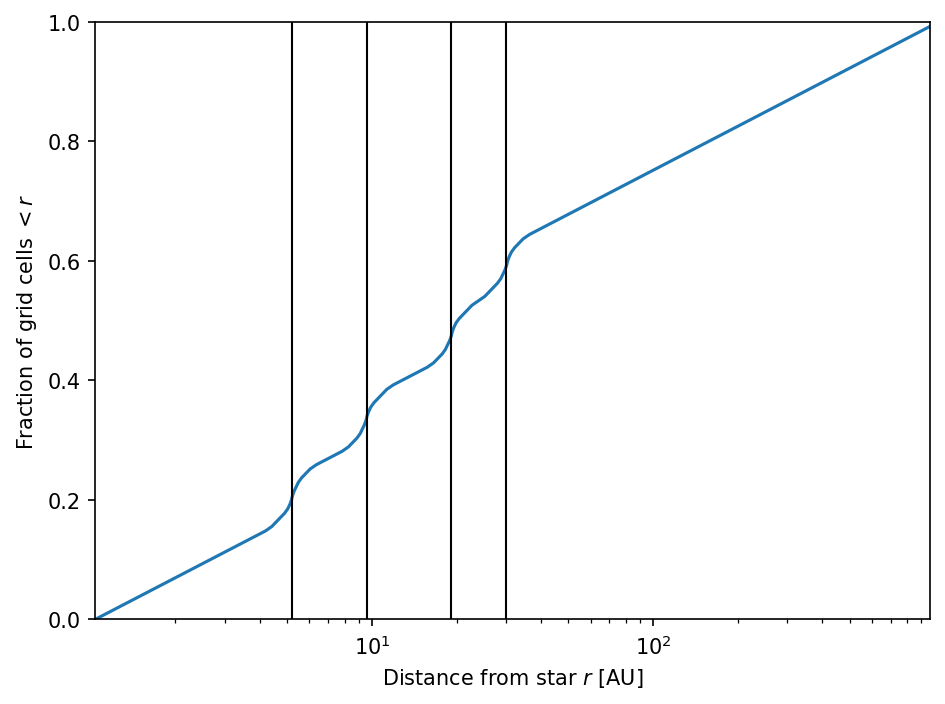

In [10]:
fig, ax = plt.subplots()
ax.semilogx(sim.grid.r/c.au, np.arange(sim.grid.Nr)/sim.grid.Nr)
for planet in planets.values():
    ax.axvline(planet["a"]/c.au, lw=1, c="black")
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
ax.set_ylim(0., 1.)
ax.set_xlabel("Distance from star $r$ [AU]")
ax.set_ylabel("Fraction of grid cells $<r$")
fig.tight_layout()

Now we are going to add the planets into their own group and give them fields for the semi-major axis and their mass. For this we are using a helper function `addplanet()`.

In [11]:
def addplanet(sim: Simulation, name: str, mass: float, semimajoraxis: float):
    if not hasattr(sim, "planets"):
        sim.addgroup("planets", description="Planetary parameters")
    sim.planets.addgroup(name)
    sim.planets.__dict__[name].addfield("a", semimajoraxis, description="Semi-major axis [cm]")
    sim.planets.__dict__[name].addfield("M", mass, description="Mass [g]")

The function is then applied to all planets in the dictionary.

In [12]:
for name, planet in planets.items():
    addplanet(sim, name, planet["M"],  planet["a"])

The simulation object has now a group with sub-groups for all the planets.

In [13]:
sim.planets

Group (Planetary parameters)
----------------------------
    Jupiter      : Group
    Neptune      : Group
    Saturn       : Group
    Uranus       : Group
  -----

In [14]:
sim.planets.Saturn

Group
-----
    a            : Field (Semi-major axis [cm])
    M            : Field (Mass [g])
  -----

Now we want to impose the gaps carved by these planets onto the gas. `DustPyLib` has several functions that return gaps shapes caused by planets. Since we are not running simulations in this notebook, we could simply impose the shapes onto the gas surface density. However, we still want to set up the model properly so it can be run later to compare it to the simple setup.

If we want to evolve the gas, we cannot simply set the gas surface density to the desired profile. It would not persist over time. We therefore apply a trick: In steady state the product of surface density and viscosity is constant. Since viscosity is proportional to the $\alpha$-parameter, the product of surface density and $\alpha$ is constant in steady state

$\large \alpha \Sigma_\mathrm{gas} = \mathrm{const.}$

If we want to create a gap in the surface density, we have to impose an equal excess onto the $\alpha$-parameter. This is what we are going to do here. For this we use the gap profile of Duffell et al. (2020), which is included in DustPyLib

In [15]:
from dustpylib.substructures.gaps import duffell2020

In [16]:
print(duffell2020.__doc__)


    Function calculates the planetary gap profile according Duffell (2020).

    Parameters
    ----------
    r : array-like, (Nr,)
        Radial grid
    a : float
        Semi-major axis of planet
    q : float
        Planet-star mass ratio
    h : float
        Aspect ratio at planet location
    alpha0 : float
        Unperturbed alpha viscosity parameter

    Returns
    -------
    f : array-like, (Nr,)
        Pertubation of surface density due to planet
    


This function needs the unperturbed $\alpha$-profile as input. We therefore store a copy of the unperturbed profile for later usage.

In [17]:
alpha0 = sim.gas.alpha.copy()

The function returns a pertubation factor that can be applied to the unperturbed gas surface density. Since we are modifying the $\alpha$-parameter, we have to multiply the unperturbed $\alpha$-profile with the inverse return value of this function.

We need to provide DustPy with a function for the $\alpha$-updater that returns our desired perturbed $\alpha$-profile. Here we iterate over all planets, interpolate the required quantities with `scipy.interpolate.interp1d` onto the planet position and divide the unperturbed $\alpha$-profile with the resulting factor.

In [18]:
from scipy.interpolate import interp1d

In [19]:
def alpha(sim):
    # Unperturbed profile
    alpha = alpha0.copy()
    # Iteration over all planets
    for name, p in sim.planets.__dict__.items():
        # Skip hidden fields in planets group:
        if name.startswith("_"):
            continue
        # Dimensionless planet mass
        q = p.M/sim.star.M
        # Interpolation of aspect ratio and alpha0 onto planet position
        f_h = interp1d(sim.grid.r, sim.gas.Hp/sim.grid.r)
        h = f_h(p.a)
        f_alp = interp1d(sim.grid.r, alpha0)
        alp = f_alp(p.a)
        # Inverse alpha-profile
        alpha /= duffell2020(sim.grid.r, p.a, q, h, alp)
    return alpha

This function has to be assigned to the updater of $\alpha$.

In [20]:
sim.gas.alpha.updater = alpha

Right now `sim.gas.alpha` still holds the unperturbed value.

In [21]:
sim.gas.alpha

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001]

To apply the pertubation we update the field and convince ourselves that it worked correctly.

In [22]:
sim.gas.alpha.update()

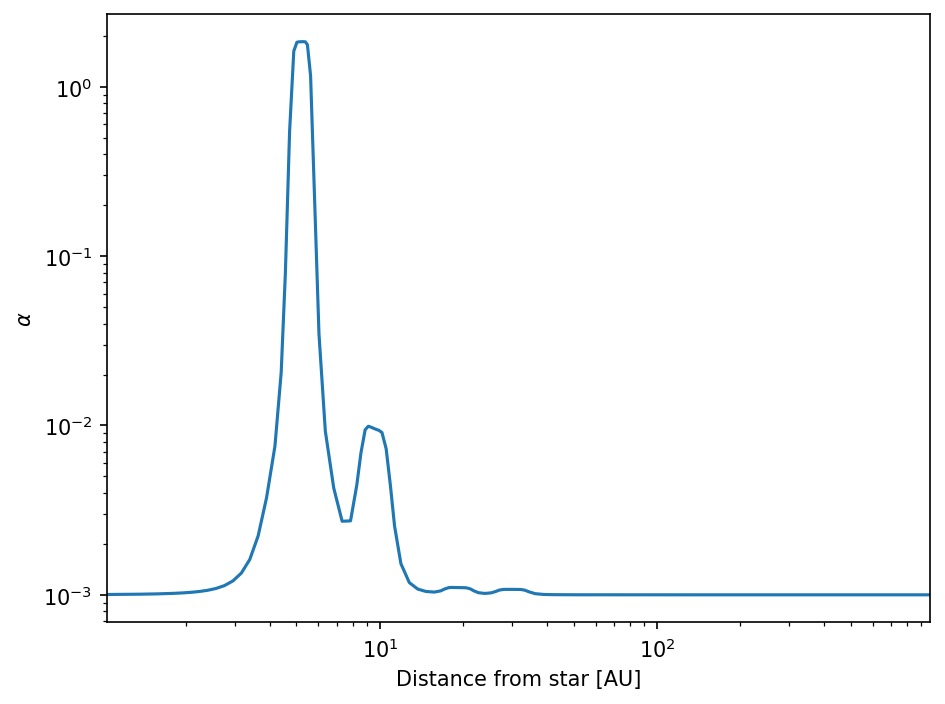

In [23]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.alpha)
ax.set_xlabel("Distance from star [AU]")
ax.set_ylabel(r"$\alpha$")
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
fig.tight_layout()

In the next step we apply the inverse $\alpha$ pertubation to the gas and dust surface densities and update the entire simulation object.

In [24]:
sim.gas.Sigma[...] /= sim.gas.alpha/alpha0
sim.dust.Sigma[...] /= (sim.gas.alpha/alpha0)[:, None]

In [25]:
sim.update()

We can use the default DustPy plotting script to inspect the simulation object.

In [26]:
from dustpy import plot

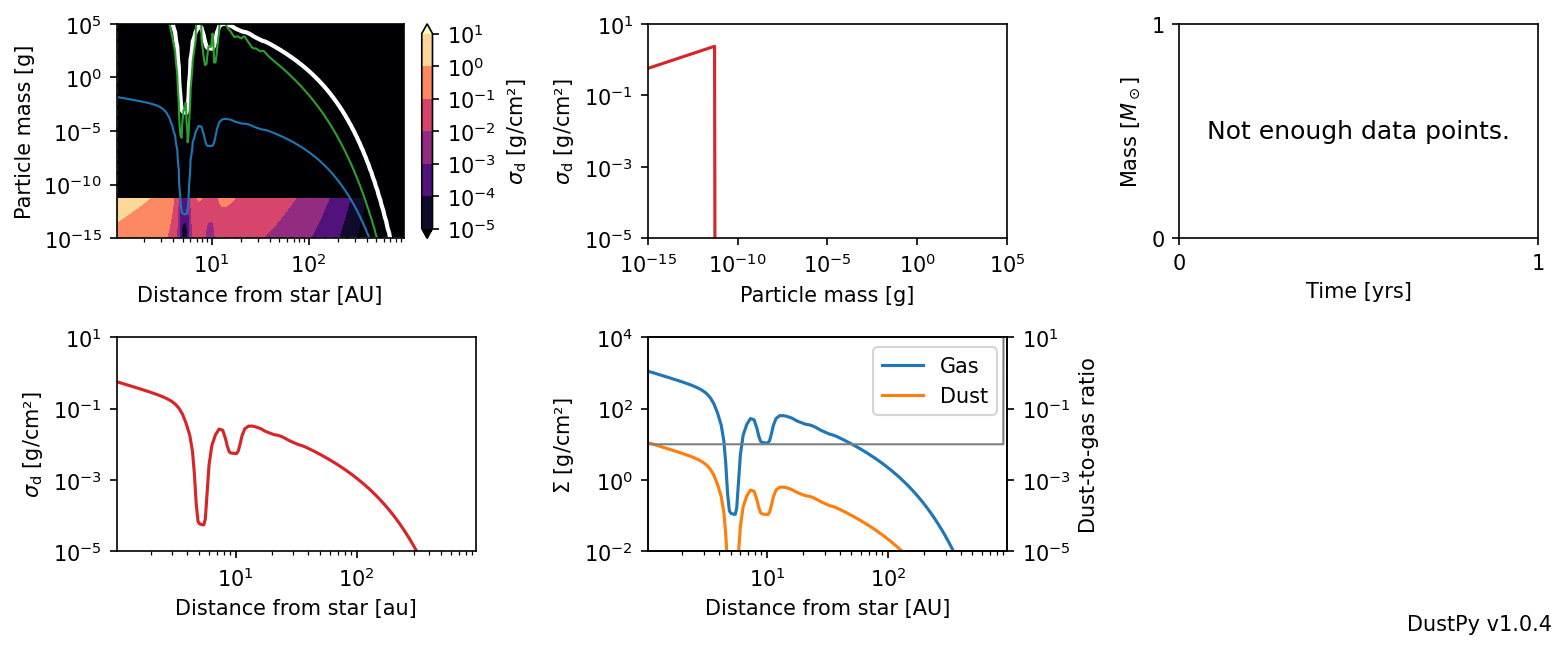

In [27]:
plot.panel(sim)

We can see that the surface densities follow the desired profiles. The particle size distribution, however, is still capped the initial maximum particle size of $1\,\mathrm{\mu m}$. In this example we would like to avoid having to run a simulation. Instead we want the particle size distribution to go until the lowest growth limit.

The Stokes number of fragmentation limited growth is given by

$\large \mathrm{St_{frag}} = \frac{v_\mathrm{frag}^2}{3\delta_\mathrm{turb}c_\mathrm{s}^2}$

In [28]:
St_frag = sim.dust.v.frag**2 / (3.*sim.dust.delta.turb * sim.gas.cs**2)

The Stokes number of drift limited growth is given by

$\Large \mathrm{St_{drift}} = \frac{\epsilon}{\gamma} \frac{v_\mathrm{K}^2}{c_\mathrm{s}^2}$

with the dust-to-gas ratio $\epsilon$ and the pressure gradient parameter

$\Large \gamma = \left| \frac{r}{P} \frac{\partial P}{\partial r} \right|$

In [29]:
# Midplane pressure: P = rho * cs**2 = Sigma / (sqrt(2*pi)*H) * cs**2 = Sigma * OmegaK * cs / sqrt(2*pi)
P = sim.gas.Sigma * sim.grid.OmegaK * sim.gas.cs / np.sqrt(2.*np.pi)
# Logarithmic interpolation on grid cell interfaces
_f = interp1d(np.log10(sim.grid.r), np.log10(P), fill_value='extrapolate')
P_i = 10.**_f(np.log10(sim.grid.ri))
#_ gamma
gamma = np.abs(sim.grid.r / P * np.diff(P_i) / np.diff(sim.grid.ri))
# Keplerian velocity
vK = sim.grid.OmegaK * sim.grid.r
St_drift = sim.dust.eps / gamma * (vK / sim.gas.cs)**2

If the particles are fragmentation-limited, we assume a size distribution of

$\Large n_\mathrm{frag} \left(a\right) \mathrm{d}a \propto a^{-3.5} \mathrm{d}a$

and if the particles are drift-limited we use a more top heavy size distribution of

$\Large n_\mathrm{drift} \left(a\right) \mathrm{d}a \propto a^{-2.5} \mathrm{d}a$

If the particles are fragmentation limited, the fragmentation Stokes number is smaller than the drift Stokes number.

In [30]:
is_frag_lim = St_frag < St_drift

The total dust surface density is the gas surface density multiplied with the dust-to-gas ratio and will be used later.

In [31]:
Sigma_dust_tot = sim.gas.Sigma * sim.dust.eps

We can now create a purely fragmentation limited dust distribution. Note that DustPy stores a mass distribution and not a size distribution and the quantity is integrated over the grid cell. The exponent is therefore increased by $4$.  
If the particles are above the fragmentation limit, the surface density is set to zero. The entire distribution is normalized to the total dust surface density.

In [32]:
Sigma_dust_frag = sim.dust.a**0.5
Sigma_dust_frag[sim.dust.St>St_frag[:, None]] = 0.
norm = Sigma_dust_frag.sum(-1)
norm = np.where(norm>0, norm, 1.)
Sigma_dust_frag *= (Sigma_dust_tot / norm)[:, None]

The same can be done for the drift-limited particle distribution.

In [33]:
Sigma_dust_drift = sim.dust.a**1.5
Sigma_dust_drift[sim.dust.St>St_drift[:, None]] = 0.
norm = Sigma_dust_drift.sum(-1)
norm = np.where(norm>0, norm, 1.)
Sigma_dust_drift *= (Sigma_dust_tot / norm)[:, None]

If the particle are fragmentation limited, we use the fragmentation-limited particle distribution. And finally we make sure that we are not below the floor value and add the new distribution to the simulation object.

In [34]:
Sigma_dust = np.where(is_frag_lim[:, None], Sigma_dust_frag, Sigma_dust_drift)
sim.dust.Sigma = np.maximum(sim.dust.SigmaFloor, Sigma_dust)

We update the simulation object and use to default plotting script to confirm, that the limits and particle distributions are correct.

In [35]:
sim.update()

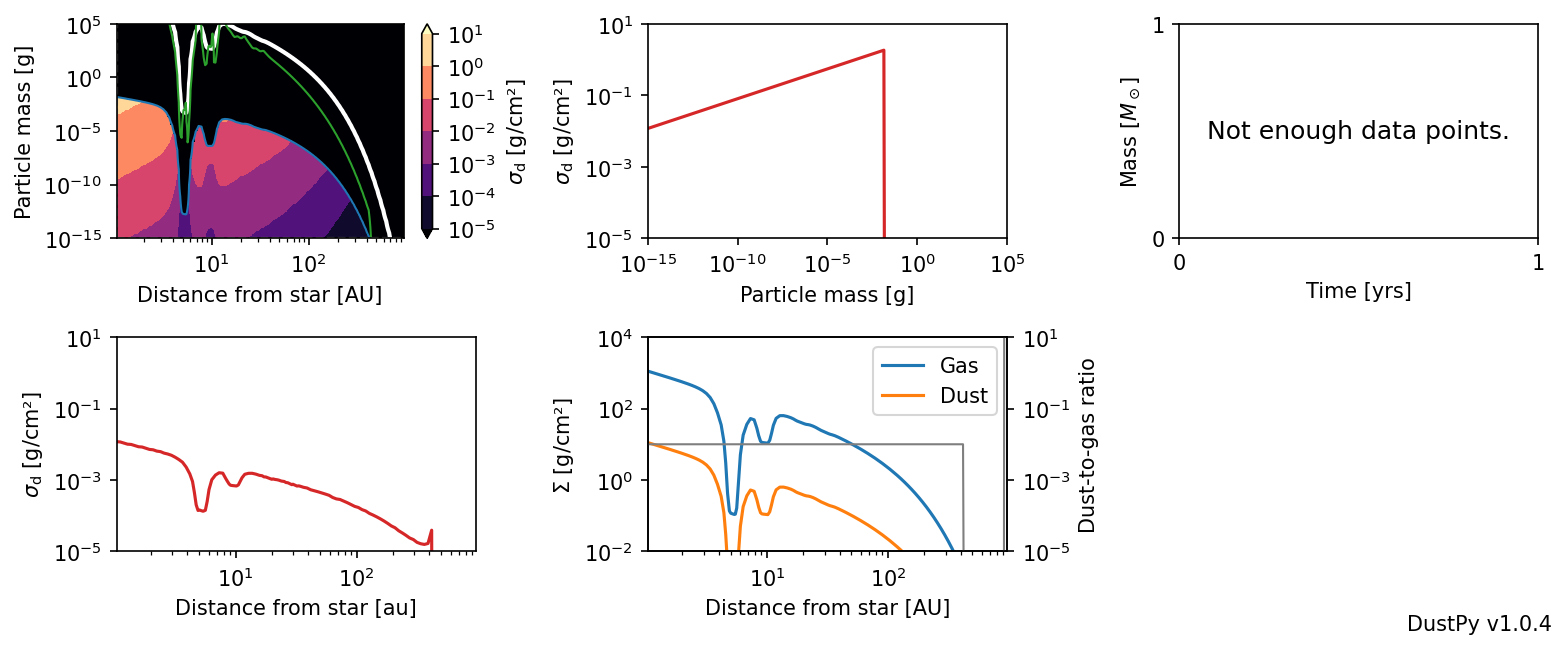

In [36]:
plot.panel(sim)

From this model we want to create a radiative transfer simulation with `RADMC-3D`. We can use the `dustpylib.radtrans.radmc3d` module of `DustPyLib` to set up the model.

Creating the model is as easy as passing the DustPy simulation object as argument.

In [37]:
from dustpylib.radtrans import radmc3d

In [38]:
rt = radmc3d.Model(sim)

Most of the parameters will be set automatically. One thing that we might want to set manually are the particle sizes we want to use in the `RADMC-3D` simulation. For this we check what the largest particle size in the DustPy model is. This is typically at the inner edge of the grid and about $1\,\mathrm{mm}$ in this case.

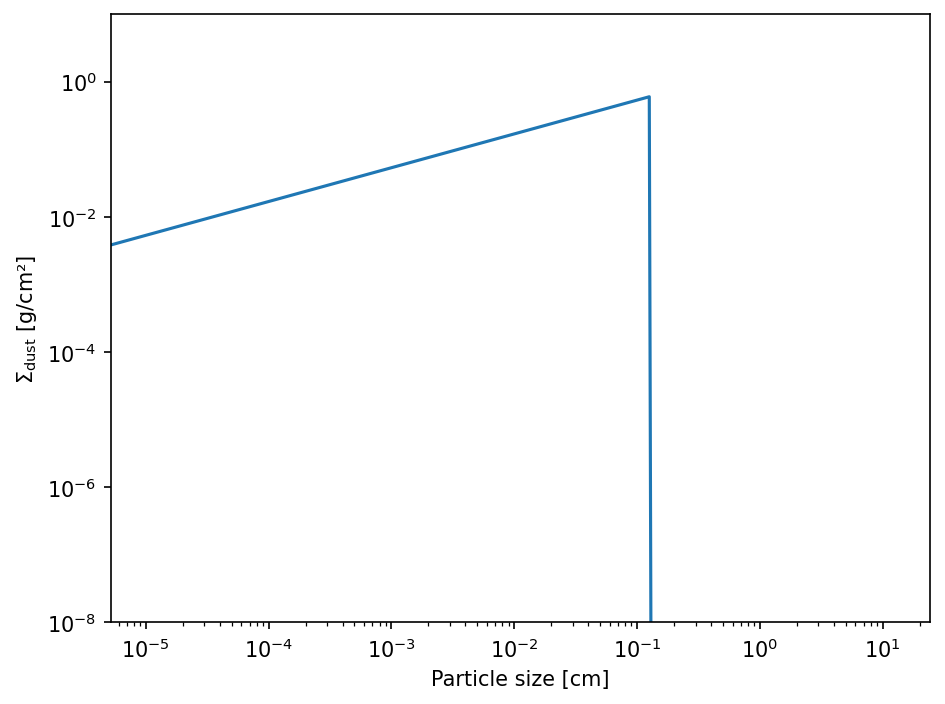

In [39]:
fig, ax = plt.subplots()
ax.loglog(rt.a_dust_[0, :], rt.Sigma_dust_[0, :])
ax.set_xlabel("Particle size [cm]")
ax.set_ylabel(r"$\Sigma_\mathrm{dust}$ [g/cm²]")
ax.set_xlim(rt.a_dust_.min(), rt.a_dust_.max())
ax.set_ylim(1.e-8, 1.e1)
fig.tight_layout()

We therefore want to use 16 particle bins from the minimum particle size until $5\,\mathrm{mm}$. We have to give the particle size bin interfaces. Therefore, we have to set $17$ interfaces.

In [40]:
rt.ai_grid = np.geomspace(rt.a_dust_.min(), 0.5, 17)

Additionally we set the number of thermal and scattering photons we want to use within `RADMC-3D`. The numbers here are on the lower end to speed up the computation. For production runs they should be increased.

In [41]:
rt.radmc3d_options["nphot"] = 1_000_000
rt.radmc3d_options["nphot_scat"] = 1_000_000

These are some more `RADMC-3D` options to speed up the simulations. Please have a look at the `RADMC-3D` documentation for details.

In [42]:
rt.radmc3d_options["mc_scat_maxtauabs"] = 5.
rt.radmc3d_options["dust_2daniso_nphi"] = 60

Finally we set the directory in which the `RADMC-3D` model files are stored.

In [43]:
rt.datadir = "radmc3d"

We can now create the input files.

In [44]:
rt.write_files()

Writing radmc3d/radmc3d.inp.....done.
Writing radmc3d/stars.inp.....done.
Writing radmc3d/wavelength_micron.inp.....done.
Writing radmc3d/amr_grid.inp.....done.
Writing radmc3d/dust_density.inp.....done.
Writing radmc3d/dust_temperature.dat.....done.
Writing radmc3d/dustopac.inp.....done.

Computing opacities...
Using dsharp_opac. Please cite Birnstiel et al. (2018).
Using DSHARP mix. Please cite Birnstiel et al. (2018).
Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| 

/home/stammler/anaconda3/envs/j/lib/python3.11/site-packages/dsharp_opac/dsharp_opac.py:2778: RuntimeWarning: invalid value encountered in scalar divide
  g[grain, i] = -2 * np.pi * np.trapz(zscat[grain, i, :, 0] * mu, x=mu) / k_sca[grain, i]



Writing radmc3d/dustkapscatmat_00.inp.....done.
Writing radmc3d/dustkapscatmat_01.inp.....done.
Writing radmc3d/dustkapscatmat_02.inp.....done.
Writing radmc3d/dustkapscatmat_03.inp.....done.
Writing radmc3d/dustkapscatmat_04.inp.....done.
Writing radmc3d/dustkapscatmat_05.inp.....done.
Writing radmc3d/dustkapscatmat_06.inp.....done.
Writing radmc3d/dustkapscatmat_07.inp.....done.
Writing radmc3d/dustkapscatmat_08.inp.....done.
Writing radmc3d/dustkapscatmat_09.inp.....done.
Writing radmc3d/dustkapscatmat_10.inp.....done.
Writing radmc3d/dustkapscatmat_11.inp.....done.
Writing radmc3d/dustkapscatmat_12.inp.....done.
Writing radmc3d/dustkapscatmat_13.inp.....done.
Writing radmc3d/dustkapscatmat_14.inp.....done.
Writing radmc3d/dustkapscatmat_15.inp.....done.

Writing radmc3d/metadata.npz.....done.


We can load the model files and inspect surface density. By default a `dust_temperature.inp` will be created using the DustPy gas temperature assuming a vertically isothermal temperature profile.

In [45]:
model = radmc3d.read_model(datadir="radmc3d")

In [46]:
def plot_model(model, spec=-1):
    """
    Function plots the RADMC-3D model.

    Parameters
    ----------
    model : namespace
        The RADMC-3D model data
    spec : integer, optional, default : -1
        Particle species to be plotted. If -1, the total
        dust densities are plotted.
    """
    width = 6.
    height = width/1.3

    if spec==-1:
        rho = np.maximum(np.hstack((model.rho[:, :1, 0, :].sum(-1), model.rho[:, :, 0, :].sum(-1))), 1.e-100)
        T = np.hstack((model.T[:, :1, :, 0], model.T[:, :, :, 0])).mean(-1)
        a_rho = "total"
        a_T = "$a$ = {:.2e} cm".format(model.grid.a[0])
    else:
        rho = np.maximum(np.hstack((model.rho[:, :1, 0, spec], model.rho[:, :, 0, spec])), 1.e-100)
        T = np.hstack((model.T[:, :1, :, spec], model.T[:, :, :, spec])).mean(-1)
        a_rho = "$a$ = {:.2e} cm".format(model.grid.a[spec])
        a_T = "$a$ = {:.2e} cm".format(model.grid.a[spec])

    rho = np.hstack((rho, np.flip(rho[:, 1:, ...], 1)))
    T = np.hstack((T, np.flip(T[:, 1:, ...], 1)))

    theta = np.hstack((model.grid.theta[0]-(model.grid.theta[1]-model.grid.theta[0]), model.grid.theta))
    theta = np.hstack((theta, theta[1:]+np.pi))
    lev_rho_max = np.ceil(np.log10(rho.max()))
    levels_rho = np.arange(lev_rho_max-6, lev_rho_max+1, 1.)

    fig, ax = plt.subplots(ncols=2, figsize=(2*width, height), subplot_kw={"projection": "polar"})

    p0 = ax[0].contourf(theta, model.grid.r/c.au, np.log10(rho), levels=levels_rho, extend="both", cmap="viridis")
    ax[0].contourf(-theta, model.grid.r/c.au, np.log10(rho), levels=levels_rho, extend="both", cmap="viridis")
    ax[0].set_theta_zero_location("N")
    ax[0].set_rlim(0)
    ax[0].set_rscale("symlog")
    ax[0].set_rgrids([1., 10., 100.], angle=-45)
    ax[0].tick_params(axis='y', colors='white')
    ax[0].set_xticks([])
    ax[0].plot(0., 0., "*", color="C3", markeredgewidth=0, markersize=12)
    cbar0 = plt.colorbar(p0)
    cbar0.set_ticks(cbar0.get_ticks())
    cbar0.set_ticklabels(["$10^{{{:d}}}$".format(int(t)) for t in cbar0.get_ticks()])
    cbar0.set_label(r"$\rho_\mathrm{dust}$ [g/cm³]")
    ax[0].set_title("Dust density, {}".format(a_rho))

    p1 = ax[1].contourf(theta, model.grid.r/c.au, T, extend="both", cmap="coolwarm")
    ax[1].contourf(-theta, model.grid.r/c.au, T, extend="both", cmap="coolwarm")
    ax[1].set_theta_zero_location("N")
    ax[1].set_rlim(0)
    ax[1].set_rscale("symlog")
    ax[1].set_rgrids([1., 10., 100.], angle=-45)
    ax[1].tick_params(axis='y', colors='black')
    ax[1].set_xticks([])
    ax[1].plot(0., 0., "*", color="C3", markeredgewidth=0, markersize=12)
    cbar1 = plt.colorbar(p1)
    cbar1.set_ticks(cbar1.get_ticks())
    cbar1.set_label(r"$T$ [K]")
    ax[1].set_title("Dust temperature, {}".format(a_T))

    fig.tight_layout()

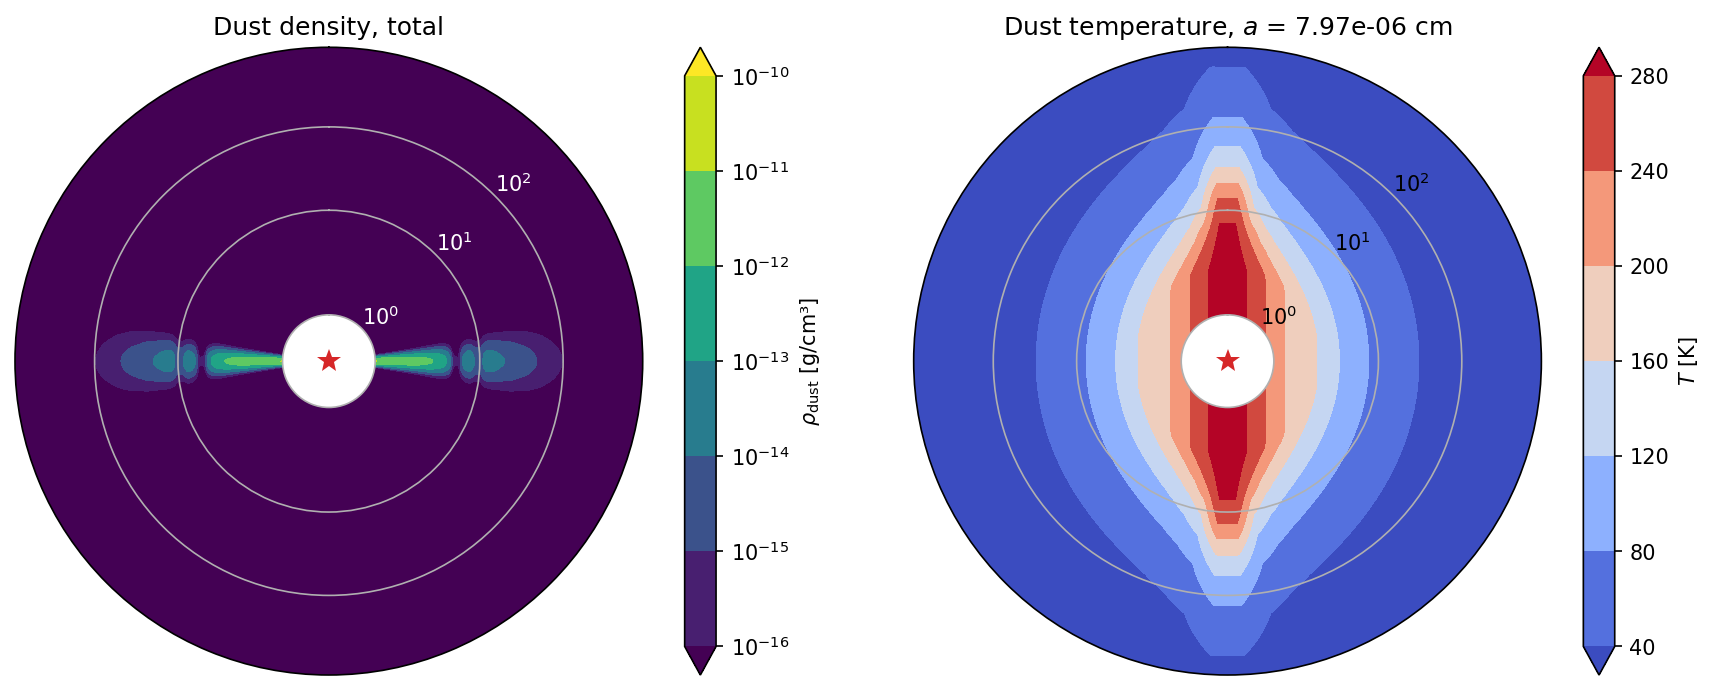

In [47]:
plot_model(model, spec=-1)

We can now run the thermal Monte-Carlo run by changing into the `RADMC-3D` model directory and running in the terminal

`radmc3d mctherm`

We can now load the model files again to confirm that the temperature profile has now been computed by `RADMC-3D`.

In [48]:
model = radmc3d.read_model(datadir="radmc3d")

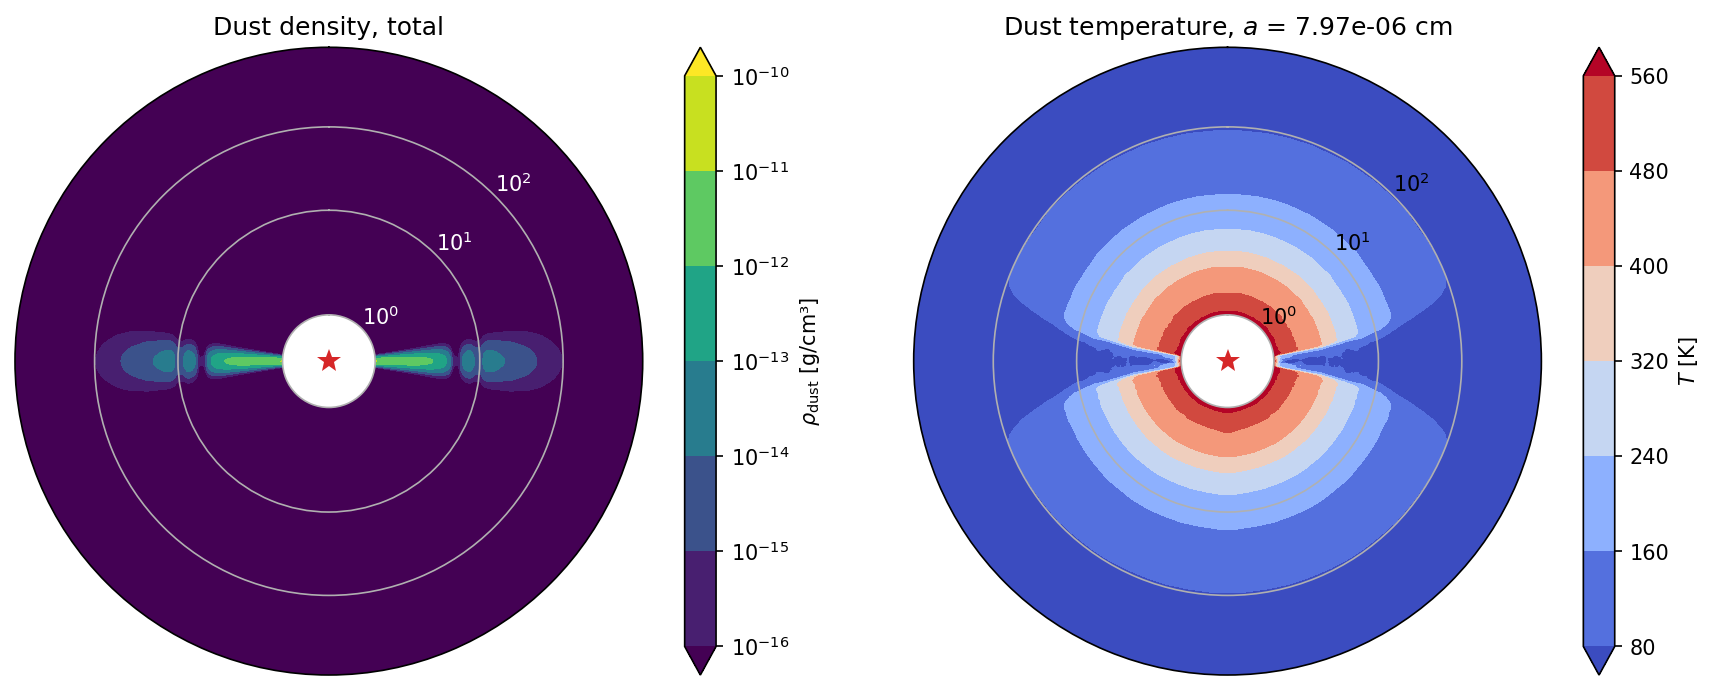

In [49]:
plot_model(model, spec=-1)

Finally, we create an image at $\lambda = 600\,\mathrm{nm}$ with some inclination and position angle with the following command

`radmc3d image lambda 0.600 sizeau 500 npixx 512 npixy 512 incl 50 posang 53`

We can load the image with the following command and plot it.

In [50]:
image = radmc3d.read_image("radmc3d/image.out")

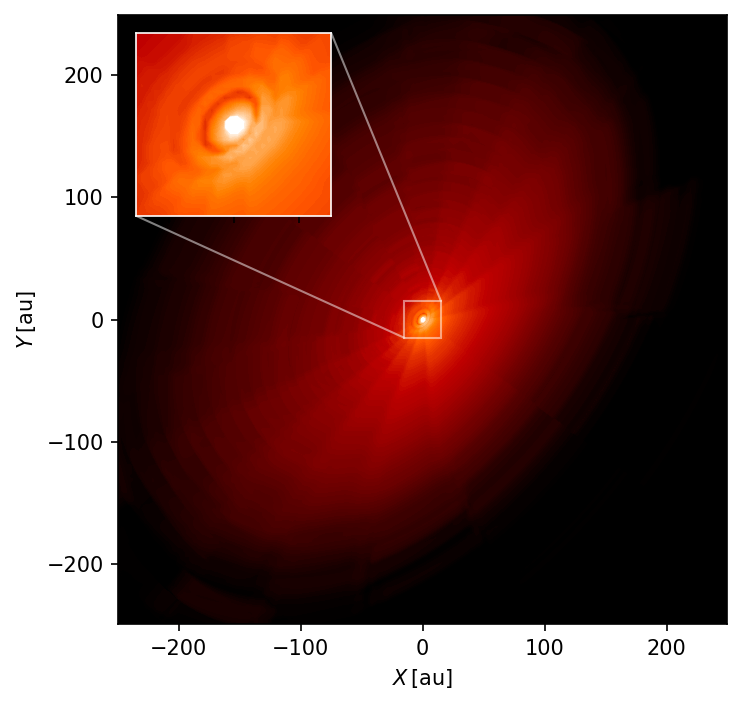

In [51]:
x, y = image["x"]/c.au, image["y"]/c.au
I = image["I"]
Imax = image["I"].max()
levmax = np.log10(Imax)-2.
levels = np.linspace(levmax-6., levmax, 100)
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.contourf(x, y, np.log10(I[..., 0].T), cmap="gist_heat", levels=levels, extend="both")
ax.set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
ax.set_ylabel(r"$Y\,\left[\mathrm{au}\right]$")
ax_ins = ax.inset_axes([0.03, 0.67, 0.32, 0.30])
ax_ins.contourf(x, y, np.log10(I[..., 0].T), cmap="gist_heat", levels=levels, extend="both")
ax_ins.set_xlim(-15, 15)
ax_ins.set_ylim(-15, 15)
ax_ins.xaxis.set_tick_params(labelbottom=False)
ax_ins.yaxis.set_tick_params(labelleft=False)
ax_ins.spines[["top", "left", "bottom", "right"]].set_color("white")
ax.indicate_inset_zoom(ax_ins, edgecolor="white")
fig.tight_layout()